In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> Numerical scheme </h1>

In [2]:
def update_state(psi, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt):

    n_modes = len(k_tab_individual)

    #recovering qubit's and mirror parameters
    omega_A = qubit_A['omega']
    gamma_A = qubit_A['gamma']
    x_A = qubit_A['x']

    omega_B = qubit_B['omega']
    gamma_B = qubit_B['gamma']
    x_B = qubit_B['x']

    omega_M = mirror['omega']
    gamma_M = mirror['gamma']

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g = psi_10[:2*n_modes]
    q_20g = psi_10[-2]
    q_10e = psi_10[-1]
    #01 one-excitation state 
    psi_01 = psi[2*n_modes + 2: 4*n_modes+4]
    q_01g = psi_01[:2*n_modes]
    q_02g = psi_01[-2]
    q_01e = psi_01[-1]

    #11 two-excitation state
    psi_11 = psi[4*n_modes+4:]
    c = psi_11[:(2*n_modes)**2].reshape(2*n_modes, 2*n_modes)

    a_21g = psi_11[(2*n_modes)**2:(2*n_modes)**2+2*n_modes]
    a_12g = psi_11[(2*n_modes)**2+2*n_modes:(2*n_modes)**2+4*n_modes]
    a_11e = psi_11[(2*n_modes)**2+4*n_modes:(2*n_modes)**2+6*n_modes]

    b_21g = psi_11[(2*n_modes)**2+6*n_modes:(2*n_modes)**2+8*n_modes]
    b_12g = psi_11[(2*n_modes)**2+8*n_modes:(2*n_modes)**2+10*n_modes]
    b_11e = psi_11[(2*n_modes)**2+10*n_modes:(2*n_modes)**2+12*n_modes]

    d_21e = psi_11[-3]
    d_12e = psi_11[-2]
    d_22g = psi_11[-1]

    #prepare the matrix multiplications
    delta_A_matrix = np.concatenate((np.ones(n_modes),np.zeros(n_modes)))
    delta_B_matrix = np.concatenate((np.zeros(n_modes),np.ones(n_modes)))
    
    coupling_matrix_A = delta_A_matrix * 1j*np.sqrt(gamma_A/L) * np.exp(-1j*(k_tab-omega_A)*t + 1j*k_tab*x_A)
    coupling_matrix_B = delta_B_matrix * 1j*np.sqrt(gamma_B/L) * np.exp(-1j*(k_tab-omega_B)*t + 1j*k_tab*x_B)
    coupling_matrix_M = 1j*np.sqrt(gamma_M/(2*L)) * np.exp(-1j*(k_tab-omega_M)*t)



    #propagate the one-excitation states
    q_10g_new = np.conjugate(coupling_matrix_M) * q_10e + np.conjugate(coupling_matrix_A) * q_20g
    q_20g_new = coupling_matrix_A @ q_10g
    q_10e_new = coupling_matrix_M @ q_10g
    psi_10_new = np.concatenate((q_10g_new, np.array([q_20g_new]),np.array([q_10e_new])))

    q_01g_new = np.conjugate(coupling_matrix_M) * q_01e + np.conjugate(coupling_matrix_B) * q_02g
    q_02g_new = coupling_matrix_B @ q_01g
    q_01e_new = coupling_matrix_M @ q_01g
    psi_01_new = np.concatenate((q_01g_new, np.array([q_02g_new]),np.array([q_01e_new])))

    #propagate the two-excitation state
    c_new = np.conjugate(coupling_matrix_M[:,np.newaxis]) @ b_11e[np.newaxis,:] + a_11e[:,np.newaxis] @ np.conjugate(coupling_matrix_M[np.newaxis,:]) \
            + np.conjugate(coupling_matrix_A[:,np.newaxis]) @ b_21g[np.newaxis,:] + a_21g[:,np.newaxis] @  np.conjugate(coupling_matrix_A[np.newaxis,:]) \
            + np.conjugate(coupling_matrix_B[:,np.newaxis]) @ b_12g[np.newaxis,:] + a_12g[:,np.newaxis] @  np.conjugate(coupling_matrix_B[np.newaxis,:])
    
    a_21g_new = c @ coupling_matrix_A + np.conjugate(coupling_matrix_B) * d_22g + np.conjugate(coupling_matrix_M) * d_21e
    a_12g_new = c @ coupling_matrix_B + np.conjugate(coupling_matrix_A) * d_22g + np.conjugate(coupling_matrix_M) * d_12e
    a_11e_new = c @ coupling_matrix_M + np.conjugate(coupling_matrix_A) * d_21e + np.conjugate(coupling_matrix_B) * d_12e 

    b_21g_new = coupling_matrix_A @ c + np.conjugate(coupling_matrix_B) * d_22g + np.conjugate(coupling_matrix_M) * d_21e
    b_12g_new = coupling_matrix_B @ c + np.conjugate(coupling_matrix_A) * d_22g + np.conjugate(coupling_matrix_M) * d_12e
    b_11e_new = coupling_matrix_M @ c + np.conjugate(coupling_matrix_A) * d_21e + np.conjugate(coupling_matrix_B) * d_12e 

    d_21e_new = coupling_matrix_A @ a_11e + coupling_matrix_A @ b_11e + coupling_matrix_M @ a_21g + coupling_matrix_M @ b_21g
    d_12e_new = coupling_matrix_B @ a_11e + coupling_matrix_B @ b_11e + coupling_matrix_M @ a_12g + coupling_matrix_M @ b_12g
    d_22g_new = coupling_matrix_A @ a_12g + coupling_matrix_A @ b_12g + coupling_matrix_B @ a_21g + coupling_matrix_B @ b_21g

    psi_11_new = np.concatenate((c_new.flatten(), a_21g_new, a_12g_new, a_11e_new, b_21g_new, b_12g_new, b_11e_new,\
                                np.array([d_21e_new]), np.array([d_12e_new]), np.array([d_22g_new])))

    psi_update = np.concatenate((psi_10_new, psi_01_new, psi_11_new))
    
    return 1j*dt*psi_update
    

In [3]:
def RG_scheme(psi_init, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=True):

    nb_pts_time = int(T / dt)
    n_modes = len(k_tab_individual)
    dimension = (2*n_modes + 2) + (2*n_modes + 2) + ((2*n_modes)**2 + 12*n_modes + 3)

    print("Subspace dimensionality: ", dimension)
    psi_list = np.zeros((nb_pts_time, dimension), dtype=complex)
    # Set the initial conditions
    psi_list[0] = psi_init

        

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        
        psi_current = psi_list[i-1]

        psi_new_1 = update_state(psi_current, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt)
        psi_new_2 = update_state(psi_current + psi_new_1/2, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_3 = update_state(psi_current + psi_new_2/2, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t + dt/2, dt)
        psi_new_4 = update_state(psi_current + psi_new_3, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, t, dt)
        
        psi_new = psi_current + (psi_new_1 + 2*psi_new_2 + 2*psi_new_3 + psi_new_4) / 6

        psi_list[i] = psi_new

    return psi_list
    

<h1> Simulator </h1>

In [4]:
def bk_simulator(qubit_A, qubit_B, mirror, omega_max, L, T, dt, print_nb_modes = False, progress_bar=True):

    #quantization of the modes
    k_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab = np.concatenate((k_tab_individual, k_tab_individual))
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #initialize the system

    #10 one-excitation state
    q_10g_init = np.zeros(2*n_modes)
    #q_10g_init = np.concatenate((np.ones(n_modes), np.zeros(n_modes))) * np.exp(-0.5* (2)**2 * (k_tab-10)**2 - 1j*k_tab*(-L/4))
    #q_10g_init /= np.sum(np.abs(q_10g_init)**2)
    q_20g_init = 1
    q_10e_init = 0
    psi_10_init = np.concatenate((q_10g_init, np.array([q_20g_init]),np.array([q_10e_init])))
    #01 one-excitation state 
    q_01g_init = np.zeros(2*n_modes)
    q_02g_init = 0
    q_01e_init = 0
    psi_01_init = np.concatenate((q_01g_init, np.array([q_02g_init]),np.array([q_01e_init])))

    #11 two-excitation state
    c_init = np.zeros((2*n_modes, 2*n_modes))

    a_21g_init = np.zeros(2*n_modes)
    a_12g_init = np.zeros(2*n_modes)
    a_11e_init = np.zeros(2*n_modes)

    b_21g_init = np.zeros(2*n_modes)
    b_12g_init = np.zeros(2*n_modes)
    b_11e_init = np.zeros(2*n_modes)

    d_21e_init = 0
    d_12e_init = 0
    d_22g_init = 0

    psi_11_init = np.concatenate((c_init.flatten(), a_21g_init, a_12g_init, a_11e_init, b_21g_init, b_12g_init, b_11e_init,\
                                np.array([d_21e_init]), np.array([d_12e_init]), np.array([d_22g_init])))

    psi_init = np.concatenate((psi_10_init, psi_01_init, psi_11_init))

    #run the evolution
    print("Evolving the state ...")
    psi_list = RG_scheme(psi_init, qubit_A, qubit_B, mirror, k_tab_individual, k_tab, L, T, dt, progress_bar=True)

    return k_tab_individual, k_tab, psi_list
    

<h1> First test </h1>

In [8]:
L = 50*pi
T = L/2
dt = 0.01

#mirror
mirror = {'omega': 10, 'gamma': 5}
#qubit A
qubit_A = {'omega': 5, 'gamma': 1, 'x':-L/4}
#qubit B
qubit_B = {'omega': 5, 'gamma': 1, 'x':-L/4}

omega_max = 20

k_tab_individual, k_tab, psi_list = bk_simulator(qubit_A, qubit_B, mirror, omega_max, L, T, dt, print_nb_modes = True, progress_bar=True)

Number of modes:  501
Evolving the state ...
Subspace dimensionality:  1012027


  0%|          | 0/7852 [00:00<?, ?it/s]

KeyboardInterrupt: 

Store the coef and observe some probabilities

In [6]:
n_modes = len(k_tab_individual)
nb_pts_time = int(T/dt)
time_list = np.linspace(0,T,nb_pts_time)

q_10g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
q_20g_list = np.zeros((nb_pts_time,), dtype=complex)
q_10e_list = np.zeros((nb_pts_time,), dtype=complex)

q_01g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
q_02g_list = np.zeros((nb_pts_time,), dtype=complex)
q_01e_list = np.zeros((nb_pts_time,), dtype=complex)

c_list = np.zeros((nb_pts_time, 2 * n_modes, 2 * n_modes), dtype=complex)

a_21g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
a_12g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
a_11e_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)

b_21g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
b_12g_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)
b_11e_list = np.zeros((nb_pts_time, 2 * n_modes), dtype=complex)

d_22g_list = np.zeros((nb_pts_time,), dtype=complex)
d_21e_list = np.zeros((nb_pts_time,), dtype=complex)
d_12e_list = np.zeros((nb_pts_time,), dtype=complex)

for i in tqdm(range(nb_pts_time)):
    psi = psi_list[i]

    #10 one-excitation state
    psi_10 = psi[:2*n_modes + 2]
    q_10g_list[i] = psi_10[:2*n_modes]
    q_20g_list[i] = psi_10[-2]
    q_10e_list[i] = psi_10[-1]
    #01 one-excitation state 
    psi_01 = psi[2*n_modes + 2: 4*n_modes+4]
    q_01g_list[i] = psi_01[:2*n_modes]
    q_02g_list[i] = psi_01[-2]
    q_01e_list[i] = psi_01[-1]

    #11 two-excitation state
    psi_11 = psi[4*n_modes+4:]
    c_list[i] = psi_11[:(2*n_modes)**2].reshape(2*n_modes, 2*n_modes)

    a_21g_list[i] = psi_11[(2*n_modes)**2:(2*n_modes)**2+2*n_modes]
    a_12g_list[i] = psi_11[(2*n_modes)**2+2*n_modes:(2*n_modes)**2+4*n_modes]
    a_11e_list[i] = psi_11[(2*n_modes)**2+4*n_modes:(2*n_modes)**2+6*n_modes]

    b_21g_list[i] = psi_11[(2*n_modes)**2+6*n_modes:(2*n_modes)**2+8*n_modes]
    b_12g_list[i] = psi_11[(2*n_modes)**2+8*n_modes:(2*n_modes)**2+10*n_modes]
    b_11e = psi_11[(2*n_modes)**2+10*n_modes:(2*n_modes)**2+12*n_modes]

    d_21e_list[i] = psi_11[-3]
    d_12e_list[i] = psi_11[-2]
    d_22g_list[i] = psi_11[-1]

  0%|          | 0/1570 [00:00<?, ?it/s]

<h1> Probabilites PA and PB </h1>

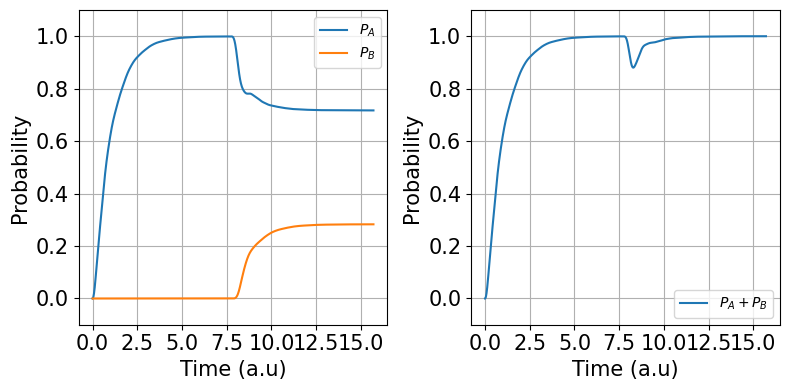

In [7]:
P_A_list = np.sum(np.abs(q_01g_list[:,:n_modes])**2, axis=1) + np.sum(np.abs(q_10g_list[:,:n_modes])**2, axis=1)
P_B_list = np.sum(np.abs(q_01g_list[:,n_modes:])**2, axis=1) + np.sum(np.abs(q_10g_list[:,n_modes:])**2, axis=1)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].plot(time_list, P_A_list, label=r'$P_A$')
ax[0].plot(time_list, P_B_list, label=r'$P_B$')


ax[1].plot(time_list, P_A_list + P_B_list, label=r'$P_A + P_B$')



#font size
for i in range(2):
    for item in [ax[i].xaxis.label, ax[i].yaxis.label]:
        item.set_fontsize(15)

    for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(15)
    
    ax[i].set_xlabel('Time (a.u)')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

<h1> Atom and qubits exictations excitation </h1>

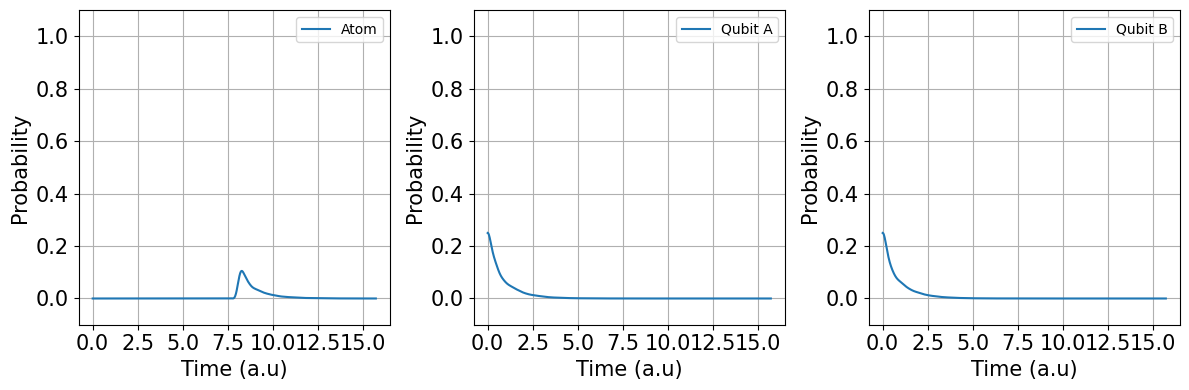

In [41]:
fig, ax = plt.subplots(1,3 , figsize=(12,4))

ax[0].plot(time_list, np.abs(q_10e_list)**2 + np.abs(q_01e_list)**2 \
         + np.abs(d_12e_list)**2 + np.abs(d_21e_list)**2 + np.sum(np.abs(a_11e_list)**2, axis=1) + np.sum(np.abs(b_11e_list)**2, axis=1), label="Atom") 

ax[1].plot(time_list, np.sum(np.abs(a_21g_list)**2, axis=1) + np.sum(np.abs(b_21g_list)**2, axis=1) \
            + np.abs(d_22g_list)**2 + np.abs(d_21e_list)**2, label="Qubit A")

ax[2].plot(time_list, np.sum(np.abs(a_12g_list)**2, axis=1) + np.sum(np.abs(b_12g_list)**2, axis=1) \
            + np.abs(d_22g_list)**2 + np.abs(d_12e_list)**2, label="Qubit B")

#font size
for i in range(3):
    for item in [ax[i].xaxis.label, ax[i].yaxis.label]:
        item.set_fontsize(15)

    for item in (ax[i].get_xticklabels() + ax[i].get_yticklabels()):
        item.set_fontsize(15)

    ax[i].set_xlabel('Time (a.u)')
    ax[i].set_ylabel('Probability')
    ax[i].grid()
    ax[i].set_axisbelow(True)  
    ax[i].set_ylim(-0.1,1.1)
    ax[i].legend(prop={'size': 10})

plt.tight_layout()
plt.show()

Check the photonic wave packet at time t

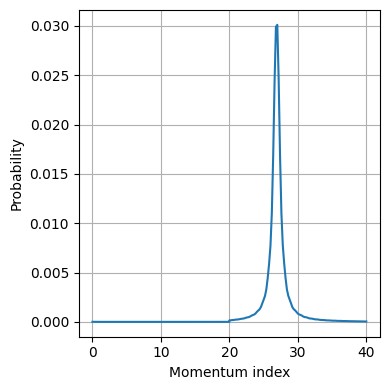

In [263]:
t = L/4
t_index = np.argmin(np.abs(time_list - t))
wave_packet = q_01g_list[t_index,:]

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(np.concatenate((k_tab_individual, omega_max + k_tab_individual)) , np.abs(wave_packet)**2)

ax.set_xlabel("Momentum index")
ax.set_ylabel("Probability")

ax.grid()
ax.set_axisbelow(True)  

plt.tight_layout()
plt.show()
